In [2]:
from sympy import symbols, Matrix, simplify, Add
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import random

In [3]:
# def generate_problem_instance(num_nodes, weight_range=(-1, 1)):
#     """
#     Generate a random problem instance for the min-cut problem.
#     :param num_nodes: Number of nodes in the graph.
#     :param weight_range: Range of weights for the edges (tuple, inclusive).
#     :return: Dictionary {(i, j): weight} representing the edges and their weights.
#     """
#     edge_dict = {}
#     for i in range(1, num_nodes + 1):
#         for j in range(i + 1, num_nodes + 1):
#             weight = round(random.uniform(weight_range[0], weight_range[1]), 2)
#             edge_dict[(i, j)] = weight
#     return edge_dict

In [4]:
# # Example usage: Generate a graph with 5 nodes
# num_nodes = 5
# edge_dict = generate_problem_instance(num_nodes)
# edge_dict

In [5]:
# Example dictionary input
edge_dict = {
    (1, 2): -2,
    (1, 3): 8,
    (2, 3): -3
}

edge_dict

{(1, 2): -2, (1, 3): 8, (2, 3): -3}

In [6]:
nodes = set()

for edge in edge_dict.keys():
    nodes.update(edge)
nodes = sorted(nodes)
node_index = {node: i for i, node in enumerate(nodes)}


size = len(nodes)
adjacency_matrix = Matrix.zeros(size, size)


for (u, v), weight in edge_dict.items():
    i, j = node_index[u], node_index[v]
    adjacency_matrix[i, j] = weight
    adjacency_matrix[j, i] = weight  # Symmetric matrix for undirected graph

In [7]:
adjacency_matrix

Matrix([
[ 0, -2,  8],
[-2,  0, -3],
[ 8, -3,  0]])

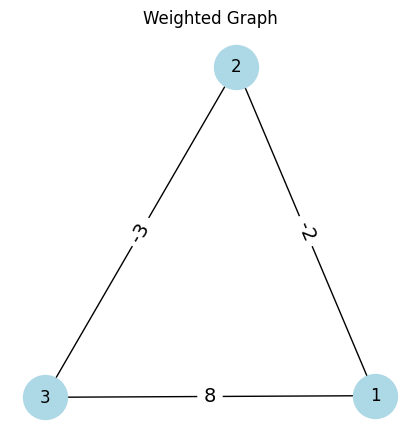

In [8]:
plt.figure(figsize=(4,4))
G = nx.Graph()

for (u, v), weight in edge_dict.items():
    G.add_edge(u, v, weight=weight)


# Create a fixed layout for the graph
pos = nx.spring_layout(G, seed=111)  # Set a seed for reproducibility

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1000)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=14)
plt.title("Weighted Graph")
plt.show()

# Formulate the QUBO Problem

The MinCut problem can be written as:
$$
\text{Objective: } \min_x \sum_{i,j} w_{ij} x_i (1 - x_j)
$$

In [9]:
n = adjacency_matrix.shape[0]
x = symbols(f"x1:{n+1}")

for i in range(n):
    for j in range(n):
        display(adjacency_matrix[i, j] * x[i] * (1 - x[j]))

qubo_expr = sum([adjacency_matrix[i, j] * x[i] * (1 - x[j]) for i in range(n) for j in range(n)])

qubo_expr

0

-2*x1*(1 - x2)

8*x1*(1 - x3)

-2*x2*(1 - x1)

0

-3*x2*(1 - x3)

8*x3*(1 - x1)

-3*x3*(1 - x2)

0

-2*x1*(1 - x2) + 8*x1*(1 - x3) - 2*x2*(1 - x1) - 3*x2*(1 - x3) + 8*x3*(1 - x1) - 3*x3*(1 - x2)

In [10]:
simplified_qubo = simplify(qubo_expr)
simplified_qubo

4*x1*x2 - 16*x1*x3 + 6*x1 + 6*x2*x3 - 5*x2 + 5*x3

In [11]:
# Extract coefficients for QUBO matrix
Q = Matrix.zeros(n, n)
for term in simplified_qubo.as_ordered_terms():
    coeff = term.as_coeff_mul()[0]
    variables = term.free_symbols
    if len(variables) == 1:  # Diagonal terms (linear coefficients)
        var = list(variables)[0]
        idx = int(str(var)[1:]) - 1
        Q[idx, idx] += coeff
    elif len(variables) == 2:  # Off-diagonal terms (quadratic coefficients)
        var1, var2 = sorted(variables, key=lambda v: int(str(v)[1:]))
        idx1, idx2 = int(str(var1)[1:]) - 1, int(str(var2)[1:]) - 1
        Q[idx1, idx2] += coeff / 2  # Account for symmetry
        Q[idx2, idx1] += coeff / 2
Q

Matrix([
[ 6,  2, -8],
[ 2, -5,  3],
[-8,  3,  5]])

# Solving the QUBO Problem

The goal is to find a binary vector $x$ such that:
$$
\min_x\ x^T Q x
$$

We will evaluate all possible binary vectors $ x $ (for small problem sizes) and compute the cost function value for each.


In [12]:
n = Q.shape[0]
x_symbols = symbols(f"x1:{n+1}")
all_possible_vectors = [Matrix([int(b) for b in f"{i:0{n}b}"]) for i in range(2**n)]
min_cost = float('inf')
optimal_vector = None
for x in all_possible_vectors:
    cost = (x.T * Q * x)[0]  # Evaluate cost function
    print(x, cost)
    if cost < min_cost:
        min_cost = cost
        optimal_vector = x

Matrix([[0], [0], [0]]) 0
Matrix([[0], [0], [1]]) 5
Matrix([[0], [1], [0]]) -5
Matrix([[0], [1], [1]]) 6
Matrix([[1], [0], [0]]) 6
Matrix([[1], [0], [1]]) -5
Matrix([[1], [1], [0]]) 5
Matrix([[1], [1], [1]]) 0


In [13]:
optimal_vector, min_cost

(Matrix([
 [0],
 [1],
 [0]]),
 -5)

# Visualization of the Optimal Cut

The optimal binary vector partitions the graph into two sets:
- Nodes with $ x_i = 0 $
- Nodes with $ x_i = 1 $

We can highlight the edges in the cut using different colors.


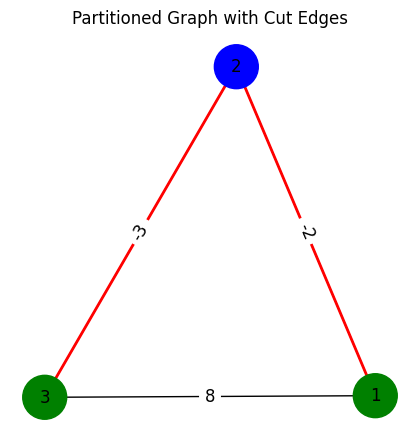

In [26]:
# Identify nodes in each partition
partition_0 = [i + 1 for i, val in enumerate(optimal_vector) if val == 0]
partition_1 = [i + 1 for i, val in enumerate(optimal_vector) if val == 1]

# Assign colors to nodes based on partition
node_colors = []
for node in G.nodes:
    if node in partition_0:
        node_colors.append("green")  # Nodes in partition 0
    elif node in partition_1:
        node_colors.append("blue")   # Nodes in partition 1

# Highlight the edges in the cut
cut_edges = [(u, v) for u, v in G.edges if (u in partition_0 and v in partition_1) or (u in partition_1 and v in partition_0)]

# Plot the graph with node colors and cut edges
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color="red", width=2)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
plt.title("Partitioned Graph with Cut Edges")
plt.show()


In [20]:
from pyqubo import Array, solve_qubo
import numpy as np

In [21]:
# Create binary variables
x = Array.create('x', shape=Q.shape[0], vartype='BINARY')

# Formulate the QUBO model
qubo_model = sum(Q[i, j] * x[i] * x[j] for i in range(Q.shape[0]) for j in range(Q.shape[1]))
qubo_model = qubo_model.compile()

# Generate the QUBO dictionary
qubo, offset = qubo_model.to_qubo()

# Solve the QUBO problem using the default solver
solution = solve_qubo(qubo)

# Extract results
optimal_solution = np.array([solution[f'x[{i}]'] for i in range(Q.shape[0])])
print("Optimal solution (binary vector):", optimal_solution)
print("Optimal cost:", sum(Q[i, j] * optimal_solution[i] * optimal_solution[j] for i in range(Q.shape[0]) for j in range(Q.shape[1])))

Optimal solution (binary vector): [1 0 1]
Optimal cost: -5


<ipython-input-21-3e0575ab8162>:12: DeprecationWarning: Call to deprecated function (or staticmethod) solve_qubo. (You should use simulated annealing sampler of dwave-neal directly.) -- Deprecated since version 0.4.0.
  solution = solve_qubo(qubo)


In [24]:
import gurobipy as gp
from gurobipy import GRB

In [ ]:
# Initialize Gurobi model
model = gp.Model("QUBO")

# Create binary variables
n = Q.shape[0]
x = model.addVars(n, vtype=GRB.BINARY, name="x")

# Add the objective function
objective = gp.QuadExpr()
for i in range(n):
    for j in range(n):
        objective += Q[i, j] * x[i] * x[j]

model.setObjective(objective, GRB.MINIMIZE)

# Optimize the model
model.optimize()

# Extract the optimal solution
optimal_solution = np.array([x[i].x for i in range(n)])
print("Optimal solution (binary vector):", optimal_solution)
print("Optimal cost:", model.objVal)